##Upload the dataset

In [28]:
from google.colab import files
uploaded = files.upload()


Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data (2).csv


In [29]:
import pandas as pd

df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


##Handle Missing values to do PCA

In [30]:
#Look for columns with NA values
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [31]:
#Fill missing BMI values with median
df['bmi']=df['bmi'].fillna(df['bmi'].median())

In [32]:
#confirm the missing values are handled
print(df.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


#Encode categorical variables to feature selection

In [33]:
# Select categorical columns to encode
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Perform one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("DataFrame after one-hot encoding:")
display(df.head())

DataFrame after one-hot encoding:


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,True,False,True,False,True,False,False,True,True,False,False
1,51676,61.0,0,0,202.21,28.1,1,False,False,True,False,False,True,False,False,False,True,False
2,31112,80.0,0,1,105.92,32.5,1,True,False,True,False,True,False,False,False,False,True,False
3,60182,49.0,0,0,171.23,34.4,1,False,False,True,False,True,False,False,True,False,False,True
4,1665,79.0,1,0,174.12,24.0,1,False,False,True,False,False,True,False,False,False,True,False


#Feature Engineering (Feature selection & reduce dimensions)

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Separate features (X) and target variable (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

# Instantiate and train the RandomForestClassifier model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Display feature importances
print("Feature Importances:")
display(sorted_feature_importances)

Feature Importances:


,0
avg_glucose_level,2.161576e-01
id,2.011062e-01
age,2.003360e-01
bmi,1.744386e-01
Residence_type_Urban,2.808386e-02
gender_Male,2.581381e-02
heart_disease,2.258308e-02
hypertension,2.249462e-02
smoking_status_never smoked,2.092379e-02
smoking_status_formerly smoked,1.952430e-02


In [50]:
# Set a threshold for feature importance
importance_threshold = 0.05 # You can adjust this threshold depending on the model accuracy

# Select features based on the threshold
selected_features = sorted_feature_importances[sorted_feature_importances > importance_threshold].index.tolist()

print(f"Selected features (importance > {importance_threshold}):")
print(selected_features)

# Create a new DataFrame with only the selected features and the target variable
# Use 'stroke' as the target column as it was not one-hot encoded
if 'stroke' in df.columns:
    df_selected = df[selected_features + ['stroke']]
else:
    print("Error: 'stroke' column not found in the DataFrame.")
    df_selected = None


if df_selected is not None:
    print("\nShape of DataFrame with selected features:", df_selected.shape)
    display(df_selected.head())

Selected features (importance > 0.05):
['avg_glucose_level', 'id', 'age', 'bmi']

Shape of DataFrame with selected features: (5110, 5)


,avg_glucose_level,id,age,bmi,stroke
0,228.69,9046,67.0,36.6,1
1,202.21,51676,61.0,28.1,1
2,105.92,31112,80.0,32.5,1
3,171.23,60182,49.0,34.4,1
4,174.12,1665,79.0,24.0,1


#Consider dimensionality reduction with PCA

Apply PCA to the selected features to reduce dimensionality.

Original number of features: 4
Reduced number of features (after PCA): 1


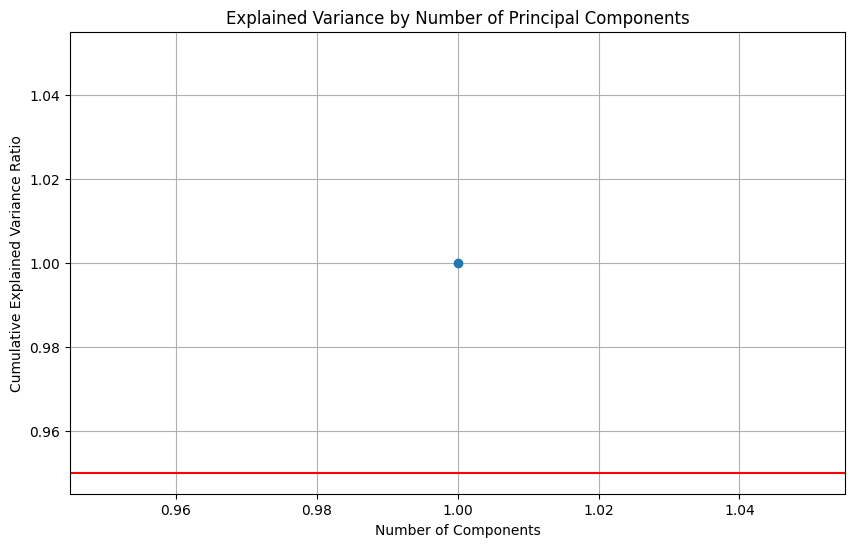

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Separate features (X) and target variable (y)
X_selected = df_selected.drop('stroke', axis=1)
y = df_selected['stroke']

# Apply PCA and keep enough components to explain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_selected)

print("Original number of features:", X_selected.shape[1])
print("Reduced number of features (after PCA):", X_pca.shape[1])

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1),
         cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')  # 95% threshold line
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()